In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
import json

# Importing the packages
from ipyleaflet import (Map, GeoData, basemaps, WidgetControl, GeoJSON,
 LayersControl, Icon, Marker,basemap_to_tiles, Choropleth,
 MarkerCluster, Heatmap,SearchControl, 
 FullScreenControl, CircleMarker)
from ipywidgets import Text, HTML

import raster_tools as rt

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

##### Load POIs, combine, assign type

In [3]:
# for each geojson in data/missoula/missoula_poi, load the geojson into a geodataframe with the name of the file as the name of the geodataframe

# get filenames with glob
import glob
filenames = glob.glob('data/missoula/missoula_poi/*.geojson')

# create a dictionary to hold the geodataframes
gdfs = {}

# loop through the filenames
for filename in filenames:
    # get the name of the file
    name = filename.split('/')[-1].split('.')[0]
    # load the geojson into a geodataframe
    gdfs[name] = gpd.read_file(filename)
    # add a column to the geodataframe with the name of the file
    gdfs[name]['b_type'] = name


In [4]:
# combine the poi geodataframes into a single geodataframe, with a new column 'type' that is the name of the original geodataframe
poi = gpd.GeoDataFrame(pd.concat(gdfs.values(), ignore_index=True))
poi['b_type'] = poi['b_type'].astype(str)
# poi['b_type'] = poi['b_type'].str.split('_').str[1:2].str[0
# split and keep everything after the first _
poi['b_type'] = poi['b_type'].str.split('_').str[1:].str.join('_')
poi['lat'] = poi.geometry.y
poi['lon'] = poi.geometry.x
poi.b_type

0          albertsons
1          albertsons
2          albertsons
3          albertsons
4      alcohol_stores
            ...      
953         warehouse
954         warehouse
955         warehouse
956         warehouse
957         warehouse
Name: b_type, Length: 958, dtype: object

In [ ]:
# distribution of business types
poi.b_type.value_counts()

In [6]:
# write pois to geojosn
poi.to_file('data/missoula/missoula_poi_all.geojson', driver='GeoJSON')

In [6]:
poi.to_crs(epsg=5070, inplace=True)

In [23]:
# load missoula_roads_segments.geojson
missoula_roads = gpd.read_file('data/missoula/missoula_roads_segments.geojson')

In [26]:
# drop roads with roadname DRIVEWAY, ALLEY
missoula_roads = missoula_roads[~missoula_roads.roadname.isin(['DRIVEWAY', 'ALLEY', 'SERVICE'])]
missoula_roads.roadname.value_counts()
missoula_roads.isnull().sum()
# drop all columns with any missing values
missoula_roads.dropna(axis=1, inplace=True)

roadname
93                      244
200                     170
83                      167
90                      166
MULLAN                  155
                       ... 
WEST FORK BEAR CREEK      1
UFFDA                     1
TONKA                     1
TIKOLAS                   1
SHAMROCK                  1
Name: count, Length: 3077, dtype: int64

In [32]:
missoula_roads

,fromleft,toleft,fromright,toright,roadname,fullroadna,zoneleft,zoneright,roadclass,status,lanes,speed,traveldir,globalid,county,zipleft,zipright,oneway,traveltime,maxheight,maxweight,commleft,commright,roadwidth,rowwidth,shape_Leng,geometry
3,1301,2077,1300,2076,ANTLER RIDGE,ANTLER RIDGE RD,CONDON,CONDON,Local,A,0,35,0,{E51958E1-A009-4ECB-B964-F4E7A23AAA06},MISSOULA,59826,59826,B,0.989166,0.0,0.0,CONDON,CONDON,0,0,928.613169,"MULTILINESTRING ((-113.66680 47.52084, -113.66..."
4,791,1299,790,1298,ANTLER RIDGE,ANTLER RIDGE RD,CONDON,CONDON,Local,A,0,35,0,{D8FDBA99-C8BE-474D-B38F-4BDBD2FFF761},MISSOULA,59826,59826,B,0.496949,0.0,0.0,CONDON,CONDON,0,0,466.527716,"MULTILINESTRING ((-113.66736 47.51693, -113.66..."
5,665,789,664,788,ANTLER RIDGE,ANTLER RIDGE RD,CONDON,CONDON,Local,A,0,35,0,{67DEA635-574E-4A99-AED1-5DD77DB649BC},MISSOULA,59826,59826,B,0.210127,0.0,0.0,CONDON,CONDON,0,0,197.264067,"MULTILINESTRING ((-113.66945 47.51591, -113.66..."
6,101,117,100,116,ANTLER RIDGE,ANTLER RIDGE RD,CONDON,CONDON,Local,A,0,35,0,{376FB6BD-E151-426D-B99F-8750A93F81BC},MISSOULA,59826,59826,B,0.040782,0.0,0.0,CONDON,CONDON,0,0,38.285232,"MULTILINESTRING ((-113.66533 47.51303, -113.66..."
7,119,663,118,662,ANTLER RIDGE,ANTLER RIDGE RD,CONDON,CONDON,Local,A,0,35,0,{EEEE96F1-FC44-4EC7-A98F-C306883CE8CF},MISSOULA,59826,59826,B,0.560843,0.0,0.0,CONDON,CONDON,0,0,526.510056,"MULTILINESTRING ((-113.66559 47.51331, -113.66..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25030,4101,4231,4100,4230,BRONCO,BRONCO DR,MILLER CREEK,MILLER CREEK,Local,A,0,25,0,{648D2E7E-9204-4009-9877-BC60613CC7CA},Missoula County,59803,59803,B,0.161502,0.0,0.0,MISSOULA,MISSOULA,0,0,108.296773,"MULTILINESTRING ((-114.05572 46.77530, -114.05..."
25062,0,0,0,0,TOLLEY,TOLLEY LN,MISSOULA,MISSOULA,Local,A,0,25,0,{B9E7764B-3E97-4892-9B75-9544443023BF},Missoula County,59803,59803,B,0.148364,0.0,0.0,MISSOULA,MISSOULA,0,0,99.486656,"MULTILINESTRING ((-114.07070 46.82071, -114.07..."
25063,5501,5699,5500,5698,HANDY,HANDY LN,MISSOULA,MISSOULA,Local,A,0,5,0,{98C71C34-3628-4ADB-9204-429D07F5AF80},Missoula County,59802,59802,B,3.368568,0.0,0.0,MISSOULA,MISSOULA,0,0,451.765430,"MULTILINESTRING ((-113.90806 46.87374, -113.90..."
25064,101,301,100,300,SHAMROCK,SHAMROCK LN,SEELEY LAKE,SEELEY LAKE,Local,A,0,5,0,{198B1FD2-B151-4512-BBF3-1AD809164B2F},Missoula County,59868,59868,B,2.396908,0.0,0.0,SEELEY LAKE,SEELEY LAKE,0,0,611.884967,"MULTILINESTRING ((-113.54349 47.22288, -113.54..."


##### Filterable map of Missoula POIs

In [5]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Load the POI data
# poi = pd.read_csv('path_to_your_poi_data.csv')  # Replace with actual path to your POI data

# Create a map centered on Missoula
m_pois = folium.Map(location=[46.87, -113.99], zoom_start=12)

# Create a color map for business types
unique_types = poi['b_type'].unique()
color_map = {b_type: f'#{hash(b_type) % 0xFFFFFF:06x}' for b_type in unique_types}

# Create a feature group for all POIs
all_pois = folium.FeatureGroup(name="All POIs", show=True)

# Add all POIs to the all_pois group
for _, row in poi.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"{row['b_type']}",
        color=color_map[row['b_type']],
        fill=True,
        fillColor=color_map[row['b_type']]
    ).add_to(all_pois)

all_pois.add_to(m_pois)

# Create a feature group for each business type
for b_type in unique_types:
    fg = folium.FeatureGroup(name=b_type, show=False)
    type_df = poi[poi['b_type'] == b_type]
    
    for _, row in type_df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            popup=f"{row['b_type']}",
            color=color_map[b_type],
            fill=True,
            fillColor=color_map[b_type]
        ).add_to(fg)
    
    fg.add_to(m_pois)

# Add layer control to the map
folium.LayerControl().add_to(m_pois)

# Add a legend
legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 180px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <p><strong>Business Types:</strong></p>
    '''
for b_type, color in color_map.items():
    legend_html += f'<p><span style="color:{color};">●</span> {b_type}</p>'
legend_html += '</div>'
m_pois.get_root().html.add_child(folium.Element(legend_html))

# Save the map
m_pois.save("missoula_poi_map.html")

print("POI map has been saved as 'missoula_poi_map.html'")

POI map has been saved as 'missoula_poi_map.html'


##### 911 Calls Data

In [6]:
# load the 911 calls data into a geodataframe
calls_911_2023 = gpd.read_file('data/missoula/missoula_911Calls_2023.csv')
calls_911_2023.geometry = gpd.points_from_xy(calls_911_2023.Lon, calls_911_2023.Lat)
calls_911_2024 = gpd.read_file('data/missoula/missoula_911_calls_2024.geojson')
calls_911_2024.geometry = gpd.points_from_xy(calls_911_2024.Lon, calls_911_2024.Lat)

In [7]:
# merge the 911 calls data
calls_911_2023_2024 = pd.concat([calls_911_2023, calls_911_2024], ignore_index=True)
# calls_911_2023_2024.to_crs(epsg=5070, inplace=True)

/var/home/jake/miniconda3/envs/GeospatialPython/lib/python3.10/site-packages/geopandas/array.py:1470: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [10]:
calls_911_2023_2024.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
missoula_roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# for each road segment, count the number of 911 calls that fall nearby the road segment (unique segemtn is a roadname + fromleft pair)
# we will want to plot the results on a map, with roads being colored by the number of 911 calls nearby

In [8]:
# load missoula_landuse_fixed.geojson
landuse = gpd.read_file('data/missoula/missoula_landuse_fixed.geojson')

In [9]:
calls_911_2023_2024

,Call Creation Date and Time,Call Number,Call Type Description,Address,Lat,Lon,geometry
0,2023-01-01 00:00:07.007,570,Driving Under the Influence,"W FRONT ST / N ORANGE ST, MISSOULA",46.8724590464427000,-113.9989803883950000,POINT (-113.99898 46.87246)
1,2023-01-01 00:03:15.223,571,Illegal Burn,"850 LOST MINE LOOP, MISSOULA",46.7814774141745000,-114.0075977399870000,POINT (-114.00760 46.78148)
2,2023-01-01 00:04:33.447,573,Fireworks,"115 MEADOWLARK CT, MISSOULA",46.8210361820536000,-114.0419021325980000,POINT (-114.04190 46.82104)
3,2023-01-01 00:04:40.103,574,Disturbance,"125 W FRONT ST, MISSOULA",46.8702541729698000,-113.9960931603860000,POINT (-113.99609 46.87025)
4,2023-01-01 00:18:26.323,575,Burglary Alarm,"3702 BROOKS ST, MISSOULA",46.8372773670512000,-114.0373361491200000,POINT (-114.03734 46.83728)
...,...,...,...,...,...,...,...
182022,2024-09-15,786,>New Call<,"2210 MULLAN RD, 315, MISSOULA",46.881935,-114.024885,POINT (-114.02488 46.88193)
182023,2024-09-15,787,Traffic Stop,"SCHRAMM ST / N RESERVE ST, MISSOULA",46.907749,-114.037425,POINT (-114.03743 46.90775)
182024,2024-09-15,788,Needs Officer's Advice,"1575 MILWAUKEE WAY, 102, MISSOULA",46.869483,-114.020145,POINT (-114.02014 46.86948)
182025,2024-09-15,789,Moving Violation,"3100 SOUTH AVE W, MISSOULA",46.850454,-114.057129,POINT (-114.05713 46.85045)


###### 911 Calls map with radius search

In [14]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import Draw
import random
import json
from branca.element import MacroElement, Template

# Load the data
gdf = calls_911_2023_2024  # Assuming this is already a GeoDataFrame

# Function to generate random color
def random_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

# Create a color map with random colors
unique_call_types = gdf['Call Type Description'].unique()
color_dict = {call_type: random_color() for call_type in unique_call_types}

# Convert GeoDataFrame to a list of dictionaries for JSON serialization
calls_data = gdf.copy()
calls_data['lat'] = calls_data.geometry.y
calls_data['lon'] = calls_data.geometry.x
calls_data = calls_data.drop(columns=['geometry']).to_dict('records')

# Create the map
m_911_radius = folium.Map(location=[46.87, -114.00], zoom_start=12)

# Add Draw plugin
draw = Draw()
draw.add_to(m_911_radius)

# Custom MacroElement to add JavaScript
class ClickForMarker(MacroElement):
    def __init__(self, calls_data, color_dict):
        super(ClickForMarker, self).__init__()
        self._template = Template("""
            {% macro script(this, kwargs) %}
            var calls_data = {{ this.calls_data }};
            var color_dict = {{ this.color_dict }};
            var currentMarker = null;

            function updateMap(lat, lon) {
                // Clear previous update results
                {{ this._parent.get_name() }}.eachLayer(function(layer) {
                    if (layer instanceof L.CircleMarker || layer instanceof L.Circle) {
                        {{ this._parent.get_name() }}.removeLayer(layer);
                    }
                });

                // Remove the current marker if it exists
                if (currentMarker) {
                    {{ this._parent.get_name() }}.removeLayer(currentMarker);
                }

                // Create a 100m buffer around the clicked point (approximate)
                var buffer_size = 0.00090;  // Approx. 100m in degrees

                // Filter calls within the buffer
                var calls_in_buffer = calls_data.filter(function(call) {
                    var dx = call.lon - lon;
                    var dy = call.lat - lat;
                    return Math.sqrt(dx*dx + dy*dy) <= buffer_size;
                });

                // Add circle to show buffer
                L.circle([lat, lon], {
                    radius: 100,
                    color: 'red',
                    fillColor: 'red',
                    fillOpacity: 0.2
                }).addTo({{ this._parent.get_name() }});

                // Add points for calls
                calls_in_buffer.forEach(function(call) {
                    L.circleMarker([call.lat, call.lon], {
                        radius: 5,
                        color: color_dict[call['Call Type Description']],
                        fillColor: color_dict[call['Call Type Description']],
                        fillOpacity: 1
                    }).bindPopup(call['Call Type Description']).addTo({{ this._parent.get_name() }});
                });

                // Create popup with top 10 call types
                var call_type_counts = {};
                calls_in_buffer.forEach(function(call) {
                    var type = call['Call Type Description'];
                    call_type_counts[type] = (call_type_counts[type] || 0) + 1;
                });

                var top_calls = Object.entries(call_type_counts)
                    .sort((a, b) => b[1] - a[1])
                    .slice(0, 10);

                var popup_html = "<h4>Top Call Types:</h4>";
                top_calls.forEach(function([call_type, count]) {
                    popup_html += call_type + ": " + count + "<br>";
                });

                L.popup()
                    .setLatLng([lat, lon])
                    .setContent(popup_html)
                    .openOn({{ this._parent.get_name() }});
            }

            {{ this._parent.get_name() }}.on('click', function(e) {
                var lat = e.latlng.lat.toFixed(6);
                var lon = e.latlng.lng.toFixed(6);
                
                // Remove the current marker if it exists
                if (currentMarker) {
                    {{ this._parent.get_name() }}.removeLayer(currentMarker);
                }
                
                // Create a new marker and store it in currentMarker
                currentMarker = L.marker([lat, lon]).addTo({{ this._parent.get_name() }});
                currentMarker.bindPopup('<button onclick="updateMap(' + lat + ',' + lon + ')">Analyze This Area</button>').openPopup();
            });
            {% endmacro %}
            """)
        self.calls_data = calls_data
        self.color_dict = color_dict

# Add the custom MacroElement to the map
m_911_radius.add_child(ClickForMarker(json.dumps(calls_data), json.dumps(color_dict)))

# Save the map
m_911_radius.save("911_calls_map.html")

print("Map saved as 911_calls_map.html")

Map saved as 911_calls_map.html


In [13]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import Draw
import random
import json
from branca.element import MacroElement, Template
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Load the data
gdf = calls_911_2023_2024  # Assuming this is already a GeoDataFrame

# Function to generate random color
def random_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

# Create a color map with random colors
unique_call_types = gdf['Call Type Description'].unique()
color_dict = {call_type: random_color() for call_type in unique_call_types}

# Convert GeoDataFrame to a list of dictionaries for JSON serialization
calls_data = gdf.copy()
calls_data['lat'] = calls_data.geometry.y
calls_data['lon'] = calls_data.geometry.x
calls_data = calls_data.drop(columns=['geometry']).to_dict('records')

# Create the map
m_911_radius = folium.Map(location=[46.87, -114.00], zoom_start=12)

# # Add Draw plugin
# draw = Draw()
# draw.add_to(m_911_radius)

# Custom MacroElement to add JavaScript
class ClickForMarker(MacroElement):
    def __init__(self, calls_data, color_dict):
        super(ClickForMarker, self).__init__()
        self._template = Template("""
            {% macro script(this, kwargs) %}
            var calls_data = {{ this.calls_data }};
            var color_dict = {{ this.color_dict }};
            var currentMarker = null;
            var currentCircle = null;

            function metersToDegreesLat(meters) {
                return meters / 111320.0; // Roughly 111,320 meters per degree of latitude
            }

            function metersToDegreesLon(meters, lat) {
                return meters / (111320.0 * Math.cos(lat * Math.PI / 180));
            }

            function updateMap(lat, lon) {
                // Get the radius in meters from the input
                var radiusMeters = parseFloat(document.getElementById('radius-input').value) || 100;
                var radiusLat = metersToDegreesLat(radiusMeters);
                var radiusLon = metersToDegreesLon(radiusMeters, lat);

                // Clear previous update results
                {{ this._parent.get_name() }}.eachLayer(function(layer) {
                    if (layer instanceof L.CircleMarker || layer instanceof L.Circle) {
                        {{ this._parent.get_name() }}.removeLayer(layer);
                    }
                });

                // Remove the current marker if it exists
                if (currentMarker) {
                    {{ this._parent.get_name() }}.removeLayer(currentMarker);
                }

                // Remove the current circle if it exists
                if (currentCircle) {
                    {{ this._parent.get_name() }}.removeLayer(currentCircle);
                }

                // Filter calls within the buffer
                var calls_in_buffer = calls_data.filter(function(call) {
                    var dx = call.lon - lon;
                    var dy = call.lat - lat;
                    return Math.sqrt(dx*dx + dy*dy) <= Math.max(radiusLat, radiusLon);
                });

                // Add circle to show buffer
                currentCircle = L.circle([lat, lon], {
                    radius: radiusMeters,
                    color: 'red',
                    fillColor: 'red',
                    fillOpacity: 0.2
                }).addTo({{ this._parent.get_name() }});

                // Add points for calls
                calls_in_buffer.forEach(function(call) {
                    L.circleMarker([call.lat, call.lon], {
                        radius: 5,
                        color: color_dict[call['Call Type Description']],
                        fillColor: color_dict[call['Call Type Description']],
                        fillOpacity: 1
                    }).bindPopup(call['Call Type Description']).addTo({{ this._parent.get_name() }});
                });

                // Create popup with top 10 call types
                var call_type_counts = {};
                calls_in_buffer.forEach(function(call) {
                    var type = call['Call Type Description'];
                    call_type_counts[type] = (call_type_counts[type] || 0) + 1;
                });

                var top_calls = Object.entries(call_type_counts)
                    .sort((a, b) => b[1] - a[1])
                    .slice(0, 10);

                var popup_html = "<h4>Top Call Types:</h4>";
                top_calls.forEach(function([call_type, count]) {
                    popup_html += call_type + ": " + count + "<br>";
                });

                L.popup()
                    .setLatLng([lat, lon])
                    .setContent(popup_html)
                    .openOn({{ this._parent.get_name() }});
            }

            {{ this._parent.get_name() }}.on('click', function(e) {
                var lat = e.latlng.lat.toFixed(6);
                var lon = e.latlng.lng.toFixed(6);
                
                // Remove the current marker if it exists
                if (currentMarker) {
                    {{ this._parent.get_name() }}.removeLayer(currentMarker);
                }
                
                // Create a new marker and store it in currentMarker
                currentMarker = L.marker([lat, lon]).addTo({{ this._parent.get_name() }});
                currentMarker.bindPopup('<button onclick="updateMap(' + lat + ',' + lon + ')">Analyze This Area</button>').openPopup();
            });

            // Add search and radius control
            var searchControl = L.Control.extend({
                options: {
                    position: 'topright'
                },
                onAdd: function (map) {
                    var container = L.DomUtil.create('div', 'leaflet-bar leaflet-control leaflet-control-custom');
                    container.style.backgroundColor = 'white';
                    container.style.padding = '5px';
                    container.innerHTML = '<input type="text" id="address-input" placeholder="Enter address in Missoula, MT">' +
                                          '<input type="number" id="radius-input" placeholder="Radius (meters)" value="100">' +
                                          '<button id="search-button">Search</button>';
                    container.style.fontSize = '14px';
                    return container;
                }
            });
            {{ this._parent.get_name() }}.addControl(new searchControl());

            document.getElementById('search-button').addEventListener('click', function() {
                var address = document.getElementById('address-input').value + ', Missoula, MT';
                fetch('https://nominatim.openstreetmap.org/search?format=json&q=' + encodeURIComponent(address))
                    .then(response => response.json())
                    .then(data => {
                        if (data.length > 0) {
                            var lat = parseFloat(data[0].lat);
                            var lon = parseFloat(data[0].lon);
                            {{ this._parent.get_name() }}.setView([lat, lon], 16);
                            if (currentMarker) {
                                {{ this._parent.get_name() }}.removeLayer(currentMarker);
                            }
                            currentMarker = L.marker([lat, lon]).addTo({{ this._parent.get_name() }});
                            currentMarker.bindPopup('<button onclick="updateMap(' + lat + ',' + lon + ')">Analyze This Area</button>').openPopup();
                        } else {
                            alert('Address not found');
                        }
                    })
                    .catch(error => {
                        console.error('Error:', error);
                        alert('An error occurred while searching for the address');
                    });
            });
            {% endmacro %}
            """)
        self.calls_data = calls_data
        self.color_dict = color_dict

# Add the custom MacroElement to the map
m_911_radius.add_child(ClickForMarker(json.dumps(calls_data), json.dumps(color_dict)))

# Save the map
m_911_radius.save("911_calls_map_2.html")

print("Map saved as 911_calls_map_2.html")

Map saved as 911_calls_map_2.html


In [22]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import Draw
import random
import json
from branca.element import MacroElement, Template

# Load the data
gdf = calls_911_2023_2024  # Assuming this is already a GeoDataFrame
poi = poi.copy()

# Function to generate random color
def random_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

# Create color maps
unique_call_types = gdf['Call Type Description'].unique()
call_color_dict = {call_type: random_color() for call_type in unique_call_types}

unique_poi_types = poi['b_type'].unique()
poi_color_map = {b_type: f'#{hash(b_type) % 0xFFFFFF:06x}' for b_type in unique_poi_types}

# Convert GeoDataFrame to a list of dictionaries for JSON serialization
calls_data = gdf.copy()
calls_data['lat'] = calls_data.geometry.y
calls_data['lon'] = calls_data.geometry.x
calls_data = calls_data.drop(columns=['geometry']).to_dict('records')

# Create the map
m_combined = folium.Map(location=[46.87, -114.00], zoom_start=12)

# Add Draw plugin
draw = Draw()
draw.add_to(m_combined)

# Create feature groups for POIs
all_pois = folium.FeatureGroup(name="All POIs", show=False)
for _, row in poi.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        popup=f"{row['b_type']}",
        color=poi_color_map[row['b_type']],
        fill=True,
        fillColor=poi_color_map[row['b_type']]
    ).add_to(all_pois)
all_pois.add_to(m_combined)

for b_type in unique_poi_types:
    fg = folium.FeatureGroup(name=f"POI: {b_type}", show=False)
    type_df = poi[poi['b_type'] == b_type]
    for _, row in type_df.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            popup=f"{row['b_type']}",
            color=poi_color_map[b_type],
            fill=True,
            fillColor=poi_color_map[b_type]
        ).add_to(fg)
    fg.add_to(m_combined)

# Custom MacroElement to add JavaScript
class ClickForMarker(MacroElement):
    def __init__(self, calls_data, call_color_dict):
        super(ClickForMarker, self).__init__()
        self._template = Template("""
            {% macro script(this, kwargs) %}
            var calls_data = {{ this.calls_data }};
            var call_color_dict = {{ this.call_color_dict }};
            var currentMarker = null;
            var currentCircle = null;
            var currentCallMarkers = L.layerGroup().addTo({{ this._parent.get_name() }});

            function metersToDegreesLat(meters) {
                return meters / 111320.0;
            }

            function metersToDegreesLon(meters, lat) {
                return meters / (111320.0 * Math.cos(lat * Math.PI / 180));
            }

            function updateMap(lat, lon) {
                var radiusMeters = parseInt(document.getElementById('radius-select').value);
                var radiusLat = metersToDegreesLat(radiusMeters);
                var radiusLon = metersToDegreesLon(radiusMeters, lat);
                                  
                // change radiusLat and radiusLon based on radiusMeters (i.e. var buffer_size = 0.00090;  Approx. 100m in degrees)
                if (radiusMeters == 10) {
                    radiusLat = 0.00010;
                    radiusLon = 0.00010;
                } else if (radiusMeters == 25) {
                    radiusLat = 0.00025;
                    radiusLon = 0.00025;
                } else if (radiusMeters == 50) {
                    radiusLat = 0.00050;
                    radiusLon = 0.00050;
                } else if (radiusMeters == 100) {
                    radiusLat = 0.00100;
                    radiusLon = 0.00100;
                } else if (radiusMeters == 200) {
                    radiusLat = 0.00200;
                    radiusLon = 0.00200;;
                }

                currentCallMarkers.clearLayers();

                if (currentCircle) {
                    {{ this._parent.get_name() }}.removeLayer(currentCircle);
                }

                currentCircle = L.circle([lat, lon], {
                    radius: radiusMeters,
                    color: 'red',
                    fillColor: 'red',
                    fillOpacity: 0.2
                }).addTo({{ this._parent.get_name() }});

                var calls_in_buffer = calls_data.filter(function(call) {
                    var dx = call.lon - lon;
                    var dy = call.lat - lat;
                    return Math.sqrt(dx*dx + dy*dy) <= Math.max(radiusLat, radiusLon);
                });

                calls_in_buffer.forEach(function(call) {
                    L.circleMarker([call.lat, call.lon], {
                        radius: 5,
                        color: call_color_dict[call['Call Type Description']],
                        fillColor: call_color_dict[call['Call Type Description']],
                        fillOpacity: 1
                    }).bindPopup(call['Call Type Description']).addTo(currentCallMarkers);
                });

                var call_type_counts = {};
                calls_in_buffer.forEach(function(call) {
                    var type = call['Call Type Description'];
                    call_type_counts[type] = (call_type_counts[type] || 0) + 1;
                });

                var top_calls = Object.entries(call_type_counts)
                    .sort((a, b) => b[1] - a[1])
                    .slice(0, 10);

                var popup_html = "<h4>Top Call Types:</h4>";
                top_calls.forEach(function([call_type, count]) {
                    popup_html += call_type + ": " + count + "<br>";
                });

                L.popup()
                    .setLatLng([lat, lon])
                    .setContent(popup_html)
                    .openOn({{ this._parent.get_name() }});
            }

            {{ this._parent.get_name() }}.on('click', function(e) {
                var lat = e.latlng.lat.toFixed(6);
                var lon = e.latlng.lng.toFixed(6);
                
                if (currentMarker) {
                    {{ this._parent.get_name() }}.removeLayer(currentMarker);
                }
                
                currentMarker = L.marker([lat, lon]).addTo({{ this._parent.get_name() }});
                currentMarker.bindPopup('<button onclick="updateMap(' + lat + ',' + lon + ')">Analyze This Area</button>').openPopup();
            });

            var searchControl = L.Control.extend({
                options: {
                    position: 'topright'
                },
                onAdd: function (map) {
                    var container = L.DomUtil.create('div', 'leaflet-bar leaflet-control leaflet-control-custom');
                    container.style.backgroundColor = 'white';
                    container.style.padding = '5px';
                    container.innerHTML = '<input type="text" id="address-input" placeholder="Enter address in Missoula, MT">' +
                                          '<select id="radius-select">' +
                                          '<option value="10">10m</option>' +
                                          '<option value="25">25m</option>' +
                                          '<option value="50">50m</option>' +
                                          '<option value="100" selected>100m</option>' +
                                          '<option value="200">200m</option>' +
                                          '</select>' +
                                          '<button id="search-button">Search</button>';
                    container.style.fontSize = '14px';
                    return container;
                }
            });
            {{ this._parent.get_name() }}.addControl(new searchControl());

            document.getElementById('search-button').addEventListener('click', function() {
                var address = document.getElementById('address-input').value + ', Missoula, MT';
                fetch('https://nominatim.openstreetmap.org/search?format=json&q=' + encodeURIComponent(address))
                    .then(response => response.json())
                    .then(data => {
                        if (data.length > 0) {
                            var lat = parseFloat(data[0].lat);
                            var lon = parseFloat(data[0].lon);
                            {{ this._parent.get_name() }}.setView([lat, lon], 16);
                            if (currentMarker) {
                                {{ this._parent.get_name() }}.removeLayer(currentMarker);
                            }
                            currentMarker = L.marker([lat, lon]).addTo({{ this._parent.get_name() }});
                            currentMarker.bindPopup('<button onclick="updateMap(' + lat + ',' + lon + ')">Analyze This Area</button>').openPopup();
                        } else {
                            alert('Address not found');
                        }
                    })
                    .catch(error => {
                        console.error('Error:', error);
                        alert('An error occurred while searching for the address');
                    });
            });
            {% endmacro %}
            """)
        self.calls_data = calls_data
        self.call_color_dict = call_color_dict

# Add the custom MacroElement to the map
m_combined.add_child(ClickForMarker(json.dumps(calls_data), json.dumps(call_color_dict)))

# Add layer control to the map
folium.LayerControl().add_to(m_combined)

# Add a legend for POIs
poi_legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 180px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <p><strong>POI Types:</strong></p>
    '''
for b_type, color in poi_color_map.items():
    poi_legend_html += f'<p><span style="color:{color};">●</span> {b_type}</p>'
poi_legend_html += '</div>'
m_combined.get_root().html.add_child(folium.Element(poi_legend_html))

# Add a legend for 911 call types
call_legend_html = '''
    <div style="position: fixed; bottom: 50px; right: 50px; width: 220px; height: 180px; 
    border:2px solid grey; z-index:9999; font-size:14px; background-color:white;
    overflow-y: auto;">
    <p><strong>911 Call Types:</strong></p>
    '''
for call_type, color in call_color_dict.items():
    call_legend_html += f'<p><span style="color:{color};">●</span> {call_type}</p>'
call_legend_html += '</div>'
m_combined.get_root().html.add_child(folium.Element(call_legend_html))

# Save the map
m_combined.save("911_poi_combined_map.html")

print("Combined map saved as 911_poi_combined_map.html")

Combined map saved as 911_poi_combined_map.html


##### 911 calls by type for each POI b_type

In [10]:
buffer_radius = 50

###### Call type counts by b_type (aggregate for all b_types)

In [ ]:
import pandas as pd
import geopandas as gpd

# Assuming calls_911_2023_2024 and poi are already GeoDataFrames in CRS 5070
calls_911_gdf = calls_911_2023_2024.to_crs(epsg=5070)
poi_gdf = poi

# Ensure the geometry columns are properly set
calls_911_gdf = calls_911_gdf.set_geometry('geometry')
poi_gdf = poi_gdf.set_geometry('geometry')

# Count the number of each b_type
b_type_counts = poi_gdf['b_type'].value_counts().reset_index()
b_type_counts.columns = ['b_type', 'POI_Count']

# Create a buffer around each POI
poi_gdf['buffer'] = poi_gdf.geometry.buffer(buffer_radius)
poi_gdf = poi_gdf.set_geometry('buffer')

# Spatial join to find calls within 50 meters of each POI
calls_near_poi = gpd.sjoin(calls_911_gdf, poi_gdf[['buffer', 'b_type']], predicate='within', how='inner')

# Group by b_type and Call Type Description
grouped = calls_near_poi.groupby(['b_type', 'Call Type Description']).size().unstack(fill_value=0)

# Calculate total for each b_type and add as a column
grouped['Total'] = grouped.sum(axis=1)

# Sort rows by total calls descending
poi_911_calls = grouped.sort_values('Total', ascending=False)

# Sort columns by total calls descending, keeping 'Total' as the last column
column_order = poi_911_calls.sum().sort_values(ascending=False).index.tolist()
column_order.remove('Total')
column_order.append('Total')
poi_911_calls = poi_911_calls[column_order]

# Add the POI count column
poi_911_calls = poi_911_calls.reset_index().merge(b_type_counts, on='b_type', how='left').set_index('b_type')

# Reorder columns to put POI_Count right after b_type
columns = poi_911_calls.columns.tolist()
columns.remove('POI_Count')
columns.insert(0, 'POI_Count')
poi_911_calls_by_b_type = poi_911_calls[columns]

# Rename the index to 'b_type'
poi_911_calls_by_b_type.index.name = 'b_type'

print(poi_911_calls_by_b_type)

# Save to CSV
poi_911_calls_by_b_type.to_csv('data/missoula/poi_911_calls_summary.csv')

###### Call type counts for each unique address (with b_type column)

In [ ]:
import pandas as pd
import geopandas as gpd

# Assuming calls_911_2023_2024 and poi are already GeoDataFrames in CRS 5070
calls_911_gdf = calls_911_2023_2024.to_crs(epsg=5070)
poi_gdf = poi

# Ensure the geometry columns are properly set
calls_911_gdf = calls_911_gdf.set_geometry('geometry')
poi_gdf = poi_gdf.set_geometry('geometry')

# Create a buffer around each POI
poi_gdf['buffer'] = poi_gdf.geometry.buffer(buffer_radius)
poi_gdf = poi_gdf.set_geometry('buffer')

# Combine b_types for POIs with the same address
poi_grouped = poi_gdf.groupby('formatted').agg({
    'b_type': lambda x: ', '.join(sorted(set(x))),
    'buffer': 'first'  # Take the first buffer for each address
}).reset_index()

# set it as a gpd
poi_grouped = gpd.GeoDataFrame(poi_grouped, geometry='buffer')
poi_grouped.crs = poi_gdf.crs

# Spatial join to find calls within 50 meters of each POI
calls_near_poi = gpd.sjoin(calls_911_gdf, poi_grouped[['buffer', 'formatted', 'b_type']], predicate='within', how='inner')

# Group by formatted address and Call Type Description
grouped = calls_near_poi.groupby(['formatted', 'Call Type Description']).size().unstack(fill_value=0)

# Calculate total for each address and add as a column
grouped['Total'] = grouped.sum(axis=1)

# Sort rows by total calls descending
poi_911_calls = grouped.sort_values('Total', ascending=False)

# Sort columns by total calls descending, keeping 'Total' as the last column
column_order = poi_911_calls.sum().sort_values(ascending=False).index.tolist()
column_order.remove('Total')
column_order.append('Total')
poi_911_calls = poi_911_calls[column_order]

# Add the b_type column
b_type_map = poi_grouped.set_index('formatted')['b_type']
poi_911_calls['b_type'] = poi_911_calls.index.map(b_type_map)

# Reorder columns to put b_type right after the index
columns = poi_911_calls.columns.tolist()
columns.remove('b_type')
columns.insert(0, 'b_type')
poi_911_calls_by_poi_address = poi_911_calls[columns]

# Rename the index to 'Address'
poi_911_calls_by_poi_address.index.name = 'Address'

print(poi_911_calls_by_poi_address)

# Save to CSV
poi_911_calls_by_poi_address.to_csv('data/missoula/poi_911_calls_summary_by_address.csv')

In [ ]:
poi_911_calls_by_poi_address

###### Total call counts for each b_type

In [ ]:
# plot poi_911_calls for each b_type, sum across all call types
poi_911_calls_by_b_type.loc[:, 'Total'].sort_values(ascending=False).plot(kind='bar', figsize=(10, 8), color='skyblue')
plt.title('Total 911 Calls by Business Type within {} Meters'.format(buffer_radius))
plt.ylabel('Total Calls')
plt.xlabel('Business Type')
plt.show()

In [ ]:
# plot poi_911_calls for each b_type, sum across all call types, scaled by the number of POIs of that type
poi_911_calls_by_b_type['Total_per_POI'] = poi_911_calls_by_b_type['Total'] / poi_911_calls_by_b_type['POI_Count']
poi_911_calls_by_b_type.loc[:, 'Total_per_POI'].sort_values(ascending=False).plot(kind='bar', figsize=(14, 10), color='skyblue')
plt.title('Total 911 Calls by Business Type per POI, scaled by number of POIs within {} Meters'.format(buffer_radius))
plt.ylabel('Total Calls per POI')
plt.xlabel('Business Type')
plt.show()

###### Filterable plot of top 10 call types for each b_type

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the data (assuming you've already created this CSV in the previous step)
poi_911_calls = pd.read_csv('data/missoula/poi_911_calls_summary.csv', index_col='b_type')

# Remove 'POI_Count' and 'Total' columns for this analysis
call_type_data = poi_911_calls.drop(['POI_Count', 'Total'], axis=1)

# Create dropdown menu options
dropdown_options = [{'label': b_type, 'value': b_type} for b_type in call_type_data.index]

# Function to get top 10 call types for a given b_type
def get_top_10_call_types(b_type):
    return call_type_data.loc[b_type].nlargest(10)

# Create the initial plot (we'll use the first b_type as default)
initial_b_type = call_type_data.index[0]
initial_data = get_top_10_call_types(initial_b_type)

fig = make_subplots(rows=1, cols=1)

bar = go.Bar(
    x=initial_data.index,
    y=initial_data.values,
    name=initial_b_type
)

fig.add_trace(bar)

# Update layout
fig.update_layout(
    title='Top 10 Call Types by POI Type within {} meters of POIs'.format(buffer_radius),
    xaxis_title='Call Type',
    yaxis_title='Number of Calls',
    updatemenus=[{
        'buttons': [
            {
                'method': 'update',
                'label': b_type,
                'args': [{'x': [get_top_10_call_types(b_type).index],
                          'y': [get_top_10_call_types(b_type).values]},
                         {'title': f'Top 10 Call Types for {b_type} within {buffer_radius} meters of POIs',}]
            } for b_type in call_type_data.index
        ],
        'direction': 'down',
        'showactive': True,
    }]
)

# Show the plot
fig.show()

# If you want to save the plot as an HTML file for later viewing:
fig.write_html("data/missoula/interactive_911_calls_plot.html")

###### Call type counts by POI as percentage of total calls for that POI

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the data
poi_911_calls = pd.read_csv('data/missoula/poi_911_calls_summary.csv', index_col='b_type')

# Remove 'POI_Count' column for this analysis
call_type_data = poi_911_calls.drop('POI_Count', axis=1)

# Function to get top 10 call types proportions for a given b_type
def get_top_10_call_types_prop(b_type):
    b_type_data = call_type_data.loc[b_type]
    total_calls = b_type_data['Total']
    proportions = (b_type_data.drop('Total') / total_calls * 100).nlargest(10)
    return proportions

# Create dropdown menu options
dropdown_options = [{'label': b_type, 'value': b_type} for b_type in call_type_data.index]

# Create the initial plot (we'll use the first b_type as default)
initial_b_type = call_type_data.index[0]
initial_data = get_top_10_call_types_prop(initial_b_type)

fig = make_subplots(rows=1, cols=1)

bar = go.Bar(
    x=initial_data.index,
    y=initial_data.values,
    name=initial_b_type,
    text=[f'{val:.2f}%' for val in initial_data.values],
    textposition='auto'
)

fig.add_trace(bar)

# Update layout
fig.update_layout(
    title=f'Top 10 Call Types for {initial_b_type} (% of Total Calls)',
    xaxis_title='Call Type',
    yaxis_title='Percentage of Calls',
    yaxis=dict(range=[0, 100]),  # Set y-axis range from 0 to 100%
    updatemenus=[{
        'buttons': [
            {
                'method': 'update',
                'label': b_type,
                'args': [{'x': [get_top_10_call_types_prop(b_type).index],
                          'y': [get_top_10_call_types_prop(b_type).values],
                          'text': [[f'{val:.2f}%' for val in get_top_10_call_types_prop(b_type).values]]},
                         {'title': f'Top 10 Call Types for {b_type} (% of Total Calls)'}]
            } for b_type in call_type_data.index
        ],
        'direction': 'down',
        'showactive': True,
    }]
)

# Show the plot
fig.show()

# Save the plot as an HTML file for later viewing
fig.write_html("data/missoula/interactive_911_calls_plot_proportional.html")

###### Categorize calls by violent and non-violent

In [27]:
# List of Violent call types
violent_calls = [
    'Assault', 'Assault with a Weapon', 'Domestic Animal', 'Homicide', 
    'Intimidation', 'Kidnapping', 'Partner Family Member Assault', 
    'Robbery', 'Sexual Assault', 'Shots Fired', 'Shots Heard', 
    'Suicidal Person', 'Suicide', 'Weapons - Carry/Possess'
]

# Function to classify call types
def classify_call(call_type):
    return 'Violent' if call_type in violent_calls else 'Nonviolent'

# Add new column 'crime_type' to the DataFrame
calls_911_2023['crime_type'] = calls_911_2023['Call Type Description'].apply(classify_call)

# Print the first few rows to verify the new column
print(calls_911_2023[['Call Type Description', 'crime_type']].head())

# Print value counts to see the distribution
print(calls_911_2023['crime_type'].value_counts())

# Optional: If you want to see the distribution as percentages
print(calls_911_2023['crime_type'].value_counts(normalize=True))

         Call Type Description  crime_type
0  Driving Under the Influence  Nonviolent
1                 Illegal Burn  Nonviolent
2                    Fireworks  Nonviolent
3                  Disturbance  Nonviolent
4               Burglary Alarm  Nonviolent
crime_type
Nonviolent    103817
Violent         3233
Name: count, dtype: int64
crime_type
Nonviolent    0.969799
Violent       0.030201
Name: proportion, dtype: float64


##### 911 Calls Time Series

###### 911 Calls Time Series by Day

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the data
df = calls_911_2023_2024
df['Call Creation Date and Time'] = df['Call Creation Date and Time'].astype('datetime64[ns]')

# Extract date
df['Date'] = df['Call Creation Date and Time'].dt.date

# Create a dataframe with each day as a row and columns for each call type
daily_counts = df.groupby(['Date', 'Call Type Description']).size().unstack(fill_value=0)

# Add a total column
daily_counts['Total'] = daily_counts.sum(axis=1)

# Sort the index to ensure chronological order
daily_counts = daily_counts.sort_index()

# Function to get top 10 call types for a given date
def get_top_10_call_types(date):
    day_data = daily_counts.loc[date].sort_values(ascending=False)
    top_10 = day_data.head(10)
    return '<br>'.join([f"{call_type}: {count}" for call_type, count in top_10.items() if call_type != 'Total'])

# Create hover text for each day
hover_text = daily_counts.index.map(get_top_10_call_types)

# Create the plot
fig = go.Figure()

# Add trace for total calls (visible by default)
fig.add_trace(
    go.Scatter(
        x=daily_counts.index,
        y=daily_counts['Total'],
        name='Total Calls',
        line=dict(color='black', width=2),
        hovertemplate='<b>Date</b>: %{x}<br>' +
                      '<b>Total Calls</b>: %{y}<br><br>' +
                      '<b>Top 10 Call Types:</b><br>%{text}',
        text=hover_text
    )
)

# Add traces for each call type (hidden by default)
for column in daily_counts.columns:
    if column != 'Total':
        fig.add_trace(
            go.Scatter(
                x=daily_counts.index,
                y=daily_counts[column],
                name=column,
                visible=False,
                hovertemplate='<b>Date</b>: %{x}<br>' +
                              f'<b>{column}</b>: %{{y}}<br><br>' +
                              '<b>Top 10 Call Types:</b><br>%{text}',
                text=hover_text
            )
        )

# Create buttons for filtering
buttons = [dict(
    label='Total Calls',
    method='update',
    args=[{'visible': [True] + [False] * (len(daily_counts.columns) - 1)},
          {'title': 'Total 911 Calls by Day'}]
)]

for i, column in enumerate(daily_counts.columns):
    if column != 'Total':
        visibility = [False] * len(daily_counts.columns)
        visibility[i + 1] = True  # +1 because Total is the first trace
        buttons.append(dict(
            label=column,
            method='update',
            args=[{'visible': visibility},
                  {'title': f'911 Calls by Day: {column}'}]
        ))

# Update layout
fig.update_layout(
    title='Total 911 Calls by Day',
    xaxis_title='Date',
    yaxis_title='Number of Calls',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
    hovermode='closest'
)

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html("data/missoula/911_calls_time_series_plot_by_day_with_popup.html")

###### 911 Calls Time Series by Hour

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Load the data
df = calls_911_2023_2024
df['Call Creation Date and Time'] = df['Call Creation Date and Time'].astype('datetime64[ns]')
df = df[df['Call Creation Date and Time'].dt.strftime('%H-%M-%S') != '00-00-00'] # Remove rows with time 00:00:00 (to avoid issues with plotting a lot of calls at midnight)

# Extract month and day, ignoring year
df['Hour'] = df['Call Creation Date and Time'].dt.hour

# Create a dataframe with each day as a row and columns for each call type
daily_counts = df.groupby(['Hour', 'Call Type Description']).size().unstack(fill_value=0)

# Add a total column
daily_counts['Total'] = daily_counts.sum(axis=1)

# Sort the index to ensure chronological order
daily_counts = daily_counts.sort_index()

# Create the plot
fig = go.Figure()

# Add trace for total calls (visible by default)
fig.add_trace(
    go.Scatter(
        x=daily_counts.index,
        y=daily_counts['Total'],
        name='Total Calls',
        line=dict(color='black', width=2)
    )
)

# Add traces for each call type (hidden by default)
for column in daily_counts.columns:
    if column != 'Total':
        fig.add_trace(
            go.Scatter(
                x=daily_counts.index,
                y=daily_counts[column],
                name=column,
                visible=False
            )
        )

# Create buttons for filtering
buttons = [dict(
    label='Total Calls',
    method='update',
    args=[{'visible': [True] + [False] * (len(daily_counts.columns) - 1)},
          {'title': 'Total 911 Calls by Hour'}]
)]

for i, column in enumerate(daily_counts.columns):
    if column != 'Total':
        visibility = [False] * len(daily_counts.columns)
        visibility[i + 1] = True  # +1 because Total is the first trace
        buttons.append(dict(
            label=column,
            method='update',
            args=[{'visible': visibility},
                  {'title': f'911 Calls by Day: {column}'}]
        ))

# Update layout
fig.update_layout(
    title='Total 911 Calls by Hour',
    xaxis_title='Hour',
    yaxis_title='Number of Calls',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )],
)

# Show the plot
fig.show()

# Save the plot as an HTML file
fig.write_html("data/missoula/911_calls_time_series_plot_by_hour.html")

##### 911 Calls 2023 Heatmap by Call Type Description

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Create DataFrame from the provided data
data = calls_911_2023
df = pd.DataFrame(data)

# Create a map centered on Missoula
m = folium.Map(location=[46.87, -113.99], zoom_start=12)

# Create a feature group for all calls
all_calls_group = folium.FeatureGroup(name="All Calls", show=False)
all_heat_data = df[['Lat', 'Lon']].values.tolist()
HeatMap(all_heat_data).add_to(all_calls_group)
all_calls_group.add_to(m)

# Get unique call types
call_types = df['Call Type Description'].unique()

# Create a feature group for each call type
for call_type in call_types:
    filtered_data = df[df['Call Type Description'] == call_type]
    heat_data = filtered_data[['Lat', 'Lon']].values.tolist()
    
    feature_group = folium.FeatureGroup(name=call_type, show=False)  # Set show=False to make layers off by default
    HeatMap(heat_data, radius=50, min_opacity=0.1, max_zoom=18).add_to(feature_group)
    feature_group.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save the map
m.save("missoula_911_heatmap_with_all_calls.html")

print("Heatmap with 'All Calls' option has been saved as 'missoula_911_heatmap_with_all_calls.html'")

##### 911 Calls 2023 Heatmap by Crime Type (violent or non-violent)

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Create DataFrame from the provided data
data = calls_911_2023
df = pd.DataFrame(data)

# Create a map centered on Missoula
m = folium.Map(location=[46.87, -113.99], zoom_start=12)

# Create a feature group for all calls
all_calls_group = folium.FeatureGroup(name="All Calls", show=False)
all_heat_data = df[['Lat', 'Lon']].values.tolist()
HeatMap(all_heat_data).add_to(all_calls_group)
all_calls_group.add_to(m)

# Get unique crime types
call_types = df['crime_type'].unique()

# Create a feature group for each crime type
for call_type in call_types:
    filtered_data = df[df['crime_type'] == call_type]
    heat_data = filtered_data[['Lat', 'Lon']].values.tolist()
    
    feature_group = folium.FeatureGroup(name=call_type, show=False)  # Set show=False to make layers off by default
    HeatMap(heat_data).add_to(feature_group)
    feature_group.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save the map
m.save("missoula_911_heatmap_with_crime_type.html")

print("Heatmap with 'All Calls' option has been saved as 'missoula_911_heatmap_with_all_calls.html'")

##### 911 Calls 2023 Heatmap by Call Hour

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Create DataFrame from the provided data
data = calls_911_2023
df = pd.DataFrame(data)

# Convert the 'Date' column to datetime and extract hour
df['Date'] = pd.to_datetime(df['Call Creation Date and Time'])
df['Hour'] = df['Date'].dt.hour

# Create a map centered on Missoula
m = folium.Map(location=[46.87, -113.99], zoom_start=12)

# Create a feature group for each hour
for hour in range(24):
    hour_df = df[df['Hour'] == hour]
    heat_data = hour_df[['Lat', 'Lon']].values.tolist()
    
    # Create a name for the layer (e.g., "12 AM" for hour 0, "1 PM" for hour 13)
    layer_name = f"{hour % 12 or 12} {'AM' if hour < 12 else 'PM'}"
    
    feature_group = folium.FeatureGroup(name=layer_name, show=False)
    HeatMap(heat_data).add_to(feature_group)
    feature_group.add_to(m)

# Add a feature group for all hours
all_heat_data = df[['Lat', 'Lon']].values.tolist()
all_hours_group = folium.FeatureGroup(name="All Hours", show=True)
HeatMap(all_heat_data).add_to(all_hours_group)
all_hours_group.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save the map
m.save("missoula_911_heatmap_hourly_layers.html")

print("Heatmap with hourly layers has been saved as 'missoula_911_heatmap_hourly_layers.html'")

##### Zillow Data

In [17]:
# load zillow data
missoula_zillow = pd.read_csv('data/missoula/missoula_zillow_10_2024.csv')
# drop values where price is less than 3 characters
missoula_zillow = missoula_zillow[missoula_zillow['price'].str.len() > 3]
missoula_zillow.reset_index(drop=True, inplace=True)

In [ ]:
missoula_zillow

In [19]:
# drop values where price is less than 3 characters
missoula_zillow = missoula_zillow[missoula_zillow['price'].str.len() > 3]
missoula_zillow.reset_index(drop=True, inplace=True)

In [ ]:
missoula_zillow.iloc[3]

In [ ]:
# show the first entry image using the image_url
from IPython.display import Image
Image(url=missoula_zillow.iloc[3].image_url)

In [ ]:
missoula_zillow.iloc[3].price

In [12]:
# missoula_zillow.address
# write address to a file and open it in a text editor
missoula_zillow.address.to_csv('missoula_zillow_addresses.txt', index=False)

In [2]:
# open missoula_zillow.csv and merge it with the missoula_zillow dataframe (original_address from missoula_zillow.csv and address from missoula_zillow df)
missoula_zillow_original = pd.read_csv('data/missoula/missoula_zillow.csv')
missoula_zillow_original

# merge the two dataframes
missoula_zillow_merged = pd.merge(missoula_zillow, missoula_zillow_original, left_on='address', right_on='original_address')
missoula_zillow_merged.to_csv('missoula_zillow_merged.csv', index=False)

NameError: name 'missoula_zillow' is not defined

In [ ]:
# format the price column to be just the number
missoula_zillow_merged['price'] = missoula_zillow_merged['price'].str.replace('$', '').str.replace(',', '').str.replace('+', '').astype(int)
missoula_zillow_merged['price']

In [31]:
missoula_zillow_merged.to_csv('missoula_zillow_merged.csv', index=False)

In [3]:
# read merged
missoula_zillow_merged = pd.read_csv('missoula_zillow_merged.csv')

<Axes: >

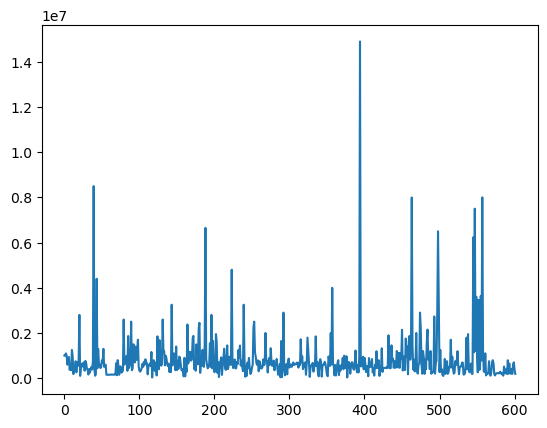

In [6]:
missoula_zillow_merged.price.plot()